# EXPLORATION_DJ 4. 영화리뷰 텍스트 감성분석하기

## 4-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

아래와 같이 다운로드를 진행해 주세요.

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

프로젝트 진행 순서는 다음과 같습니다.

### 1) 데이터 준비와 확인
---

In [1]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from konlpy.tag import Okt
import re
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
%matplotlib inline

# 데이터를 읽어봅시다.
train_data = pd.read_table('~/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
---
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘',
             '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + \
        [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


x_train, y_train, x_test, y_test, word_to_index = load_data(
    train_data, test_data)

In [3]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.


def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.


def get_decoded_sentence(encoded_sentence, index_to_word):
    # [1:]를 통해 <BOS>를 제외
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포

In [5]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


- 적절한 최대 문장 길이 지정

In [6]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(
    np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre',  # 혹은 'post'
                                                     maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',  # 혹은 'post'
                                                    maxlen=maxlen)

print(x_train.shape)

(146182, 41)


### 4) 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [71]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [10]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_1.add(keras.layers.LSTM(8))
model_1.add(keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.MaxPooling1D(5))
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.GlobalMaxPooling1D())
model_2.add(keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [8]:
# validation set 5000건 분리
x_val = x_train[:5000]
y_val = y_train[:5000]

# validation set을 제외한 나머지
partial_x_train = x_train[5000:]
partial_y_train = y_train[5000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(141182, 41)
(141182,)


### 5) 모델 훈련 개시
---

In [13]:
model_1.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
model_3.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])

In [14]:
epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

In [15]:
history_1 = model_1.fit(partial_x_train, partial_y_train, epochs=epochs,
                        batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
276/276 [==============================] - 2s 6ms/step - loss: 0.4836 - accuracy: 0.7879 - val_loss: 0.3473 - val_accuracy: 0.8548
Epoch 2/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3347 - accuracy: 0.8590 - val_loss: 0.3299 - val_accuracy: 0.8582
Epoch 3/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3122 - accuracy: 0.8696 - val_loss: 0.3358 - val_accuracy: 0.8558
Epoch 4/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2988 - accuracy: 0.8751 - val_loss: 0.3285 - val_accuracy: 0.8604
Epoch 5/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2869 - accuracy: 0.8796 - val_loss: 0.3313 - val_accuracy: 0.8602
Epoch 6/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2745 - accuracy: 0.8856 - val_loss: 0.3349 - val_accuracy: 0.8596
Epoch 7/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2639 - accuracy: 0.8901 - val_loss: 0.3392 - val_accuracy: 0.8568
Epoch 

In [16]:
history_2 = model_2.fit(partial_x_train, partial_y_train, epochs=epochs,
                        batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
276/276 [==============================] - 8s 30ms/step - loss: 0.4662 - accuracy: 0.7722 - val_loss: 0.3354 - val_accuracy: 0.8568
Epoch 2/20
276/276 [==============================] - 1s 4ms/step - loss: 0.3232 - accuracy: 0.8620 - val_loss: 0.3255 - val_accuracy: 0.8600
Epoch 3/20
276/276 [==============================] - 1s 5ms/step - loss: 0.2889 - accuracy: 0.8793 - val_loss: 0.3273 - val_accuracy: 0.8618
Epoch 4/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2565 - accuracy: 0.8959 - val_loss: 0.3311 - val_accuracy: 0.8618
Epoch 5/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2226 - accuracy: 0.9130 - val_loss: 0.3510 - val_accuracy: 0.8564
Epoch 6/20
276/276 [==============================] - 1s 4ms/step - loss: 0.1888 - accuracy: 0.9291 - val_loss: 0.3816 - val_accuracy: 0.8466
Epoch 7/20
276/276 [==============================] - 1s 4ms/step - loss: 0.1579 - accuracy: 0.9439 - val_loss: 0.4136 - val_accuracy: 0.8424
Epoch

In [17]:
history_3 = model_3.fit(partial_x_train, partial_y_train, epochs=epochs,
                        batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
276/276 [==============================] - 1s 4ms/step - loss: 0.5750 - accuracy: 0.7242 - val_loss: 0.4140 - val_accuracy: 0.8304
Epoch 2/20
276/276 [==============================] - 1s 4ms/step - loss: 0.3703 - accuracy: 0.8430 - val_loss: 0.3489 - val_accuracy: 0.8470
Epoch 3/20
276/276 [==============================] - 1s 4ms/step - loss: 0.3213 - accuracy: 0.8648 - val_loss: 0.3391 - val_accuracy: 0.8544
Epoch 4/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2951 - accuracy: 0.8780 - val_loss: 0.3392 - val_accuracy: 0.8576
Epoch 5/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2756 - accuracy: 0.8872 - val_loss: 0.3446 - val_accuracy: 0.8574
Epoch 6/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2595 - accuracy: 0.8954 - val_loss: 0.3531 - val_accuracy: 0.8560
Epoch 7/20
276/276 [==============================] - 1s 4ms/step - loss: 0.2458 - accuracy: 0.9021 - val_loss: 0.3626 - val_accuracy: 0.8496
Epoch 

In [18]:
results_1 = model_1.evaluate(x_test, y_test, verbose=2)

print(results_1)

1537/1537 - 2s - loss: 0.5348 - accuracy: 0.8406
[0.5347868800163269, 0.8405923843383789]


In [19]:
results_2 = model_2.evaluate(x_test, y_test, verbose=2)

print(results_2)

1537/1537 - 4s - loss: 0.9535 - accuracy: 0.8190
[0.9534959197044373, 0.8190288543701172]


In [21]:
results_3 = model_3.evaluate(x_test, y_test, verbose=2)

print(results_3)

1537/1537 - 1s - loss: 0.5388 - accuracy: 0.8251
[0.538797914981842, 0.8250706791877747]


### 6) Loss, Accuracy 그래프 시각화
---

In [23]:
history_dict_1 = history_1.history
history_dict_2 = history_2.history
history_dict_3 = history_3.history

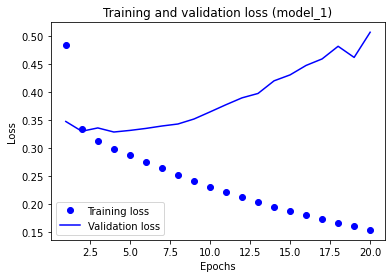

In [25]:
acc = history_dict_1['accuracy']
val_acc = history_dict_1['val_accuracy']
loss = history_dict_1['loss']
val_loss = history_dict_1['val_loss']

epochs = range(1, len(acc)+1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (model_1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

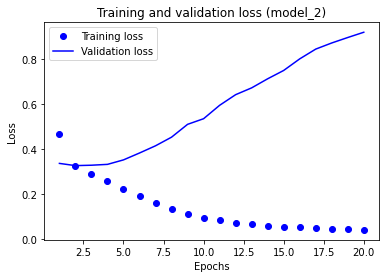

In [28]:
plt.clf()   # 그림을 초기화합니다

acc = history_dict_2['accuracy']
val_acc = history_dict_2['val_accuracy']
loss = history_dict_2['loss']
val_loss = history_dict_2['val_loss']

epochs = range(1, len(acc)+1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (model_2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

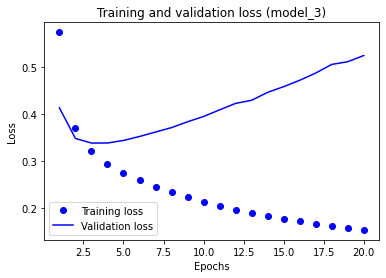

In [29]:
plt.clf()   # 그림을 초기화합니다

acc = history_dict_3['accuracy']
val_acc = history_dict_3['val_accuracy']
loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']

epochs = range(1, len(acc)+1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (model_3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석
---

In [69]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [73]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.getenv('HOME')+'/sentiment_classification/temp.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(
        map(str, list(vectors[i, :])))))
f.close()

In [74]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    word2vec_file_path, binary=False)
vector = word_vectors['김치']
vector

array([ 0.12680978,  0.11970817,  0.03286076, -0.28068236,  0.08188361,
        0.04021413,  0.06784941,  0.16090645, -0.10359363,  0.02278912,
       -0.0008241 , -0.28035998,  0.19000293,  0.04122482, -0.03123098,
       -0.19546679], dtype=float32)

In [75]:
word_vectors.similar_by_word("김치")

[('위기', 0.9493103623390198),
 ('독', 0.9464215040206909),
 ('닭', 0.9339830875396729),
 ('출발', 0.9307951331138611),
 ('음침', 0.9284548759460449),
 ('의심', 0.9237082004547119),
 ('실험', 0.9214313626289368),
 ('조폭', 0.9198734760284424),
 ('생각없이', 0.9186272025108337),
 ('아무래도', 0.9182350635528564)]

> 제한적인 데이터로 학습해서 그런지 김치와 전혀 연관없는 단어들이 튀어나온다.

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

[https://github.com/Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

In [76]:
import os
from gensim.models import Word2Vec

In [77]:
word2vec_path = os.getenv('HOME')+'/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [78]:
word2vec.wv.most_similar("김치")

[('콩나물', 0.7347515225410461),
 ('고추장', 0.7271528244018555),
 ('젓갈', 0.7212152481079102),
 ('불고기', 0.7191970348358154),
 ('고구마', 0.7076905965805054),
 ('식초', 0.7076483964920044),
 ('닭고기', 0.707370400428772),
 ('육수', 0.7067707180976868),
 ('된장', 0.7039382457733154),
 ('양배추', 0.7038015127182007)]

> 그래도 이건 제법 연관성 있어보이는 단어들이 나온다.

In [110]:
vocab_size = 10000     # 어휘 사전의 크기입니다
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [111]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel-dj61/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/home/aiffel-dj61/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [112]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model_4 = keras.Sequential()
model_4.add(keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(
                                       embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))        # trainable을 True로 주면 Fine-tuning
model_4.add(keras.layers.LSTM(8))
model_4.add(keras.layers.Dense(8, activation='relu'))
model_4.add(keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [120]:
# validation set 1000건 분리
x_val = x_train[:30000]
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = x_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [121]:
# 학습의 진행
model_4.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

epochs = 3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_4 = model_4.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

Epoch 1/3
227/227 [==============================] - 6s 28ms/step - loss: 0.2676 - accuracy: 0.8922 - val_loss: 0.2686 - val_accuracy: 0.8904
Epoch 2/3
227/227 [==============================] - 6s 27ms/step - loss: 0.2537 - accuracy: 0.9001 - val_loss: 0.2772 - val_accuracy: 0.8848
Epoch 3/3
227/227 [==============================] - 6s 26ms/step - loss: 0.2412 - accuracy: 0.9055 - val_loss: 0.2893 - val_accuracy: 0.8777


In [122]:
# 테스트셋을 통한 모델 평가
results_4 = model_4.evaluate(x_test,  y_test, verbose=2)

print(results_4)

1537/1537 - 3s - loss: 0.3585 - accuracy: 0.8504
[0.3585129380226135, 0.8503977060317993]


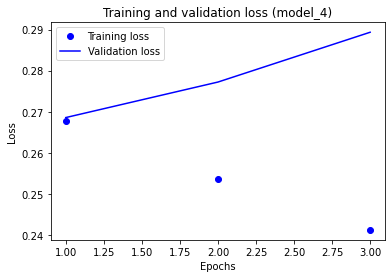

In [123]:
history_dict_4 = history_4.history

acc = history_dict_4['accuracy']
val_acc = history_dict_4['val_accuracy']
loss = history_dict_4['loss']
val_loss = history_dict_4['val_loss']

epochs = range(1, len(acc)+1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (model_4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성|

### 후기
---
이번 과제는 계속 일정이 있어 미루고 미루다 마감일이 다 되어 제출하게 되었다.  
그만큼 제대로 공부하면서 진행하지는 못 했고, 마지막에 85% 이상 달성하는 것에 초점을 두었다.  

전체적으로 자연어처리를 조금 맛보는 것에 의의를 두었는데, 아쉬운 점은 딥러닝 모델을 사용하는 방법, 파라미터 등에 대해 제대로 공부하지 못하고 넘어가게 되었다는 것이다.  
시간이 넉넉하면 다양하게 조절해서 시험해보고 싶으나, 그것 또한 효율적으로 진행하기 위해서는 각 파라미터의 뜻을 알아야하고, 알고리즘에 대한 이해도 바탕이 되어야 할 것 같다.  

앞으로 CS231n 수업 등을 꾸준히 공부하여 더 실력을 키워야겠다.